Traveling Salesman Problem

In [32]:
from networkx.algorithms import tree
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import heapq as heap
import sys
import time
import signal
import csv
import tracemalloc

Algorithms

Branch and Bound

In [33]:
class Node:
    def __init__(self, bounds, nivel, custo, solucao):
        self.bounds = bounds
        self.nivel = nivel
        self.custo = custo
        self.solucao = solucao
        
    def __lt__(self, other):
        if(self.bounds < other.bounds):
            return True
        else:
            if(self.bounds == other.bounds):
                if(self.nivel > other.nivel):
                    return True
                else:
                    if(self.solucao[self.nivel] < other.solucao[other.nivel]):
                        return True
        return False

def bound(matrix, solucao):
    soma = 0
    tamanho = len(matrix[0][:])
    resto = []
    for i in range(tamanho):
        if i not in solucao:
            resto.append(i)
    for i in range(len(solucao) - 1):
        soma += matrix[solucao[i]][solucao[i + 1]]
    min = np.inf
    for i in resto:
        if(matrix[solucao[-1]][i] < min):
            min = matrix[solucao[-1]][i]
    if(len(resto) != 0):
        soma += min
    p = [solucao[0]] + resto
    for r in resto:
        min = np.inf
        for i in p:
            if(i != r):
                if(matrix[r][i] < min):
                    min = matrix[r][i]
        soma += min
        
    return soma

def boundFinal(matrix, solucao):
    soma = 0
    for i in range(len(solucao) - 1):
        soma += matrix[solucao[i]][solucao[i + 1]]
    return np.ceil(soma)

def eliminarDuploSentido(matrix, solucao):
    for i in solucao:
        if(i == 1):
            return True
        if(i == 2):
            return False
    return True

In [34]:
def bnbTsp(G, A, n):
    raiz = Node(bound(A, [0]), 0, 0, [0])
    fila = []
    heap.heapify(fila)
    heap.heappush(fila, raiz)
    melhorValor = np.inf
    melhorSolucao = []
    while (len(fila) != 0):
        no = heap.heappop(fila)
        if(no.nivel > n - 1):
            if(melhorValor > no.custo):
                melhorValor = no.custo
                melhorSolucao = no.solucao
        else:
            if(no.bounds < melhorValor):
                if(no.nivel < n - 1):
                    for k in range(n):
                        if(k not in no.solucao) and (A[no.solucao[-1]][k] != np.inf) and (bound(A, np.append(no.solucao, k)) < melhorValor):
                            if(eliminarDuploSentido(A, no.solucao)):
                                novoNo = Node(bound(A, np.append(no.solucao, k)), no.nivel + 1, no.custo + A[no.solucao[-1]][k], np.append(no.solucao, k))
                                heap.heappush(fila, novoNo)
                else:
                    if(A[no.solucao[-1]][0] != np.inf and boundFinal(A, np.append(no.solucao, 0)) < melhorValor):
                        novoNo = Node(boundFinal(A, np.append(no.solucao, 0)), no.nivel + 1, no.custo + A[no.solucao[-1]][0], np.append(no.solucao, 0))
                        heap.heappush(fila, novoNo)

    return melhorSolucao, melhorValor

Twice Around the Tree

In [35]:
def approxTspTour(G, A, c):
    arvoreMinima = tree.minimum_spanning_tree(G,algorithm="prim")
    caminhamentoPreOrdem = nx.dfs_preorder_nodes(arvoreMinima, source=0)
    cicloHamiltoniano = list(caminhamentoPreOrdem) + [0]
    custo = boundFinal(A, cicloHamiltoniano)
    
    return cicloHamiltoniano, custo

Christofides

In [36]:
def approxTspChristofides(G, A, c):
    arvoreMinima = tree.minimum_spanning_tree(G, algorithm="prim")
    verticesImpares = []
    for i in range(c):
        if(arvoreMinima.degree()[i] % 2 == 1):
            verticesImpares.append(i)
    grafoInduzido = nx.Graph(G.subgraph(verticesImpares))
    matchMinimo = nx.min_weight_matching(grafoInduzido)
    multigrafo = nx.MultiGraph(arvoreMinima)
    for (u,v) in matchMinimo:
        tripla = (u, v, A[u][v])
        multigrafo.add_weighted_edges_from([tripla])
    circuitoEuliriano = nx.eulerian_circuit(multigrafo)
    solucao = []
    visitados = [False] * c
    for u,v in circuitoEuliriano:
        if(visitados[u] == False):
            solucao += [u]
            visitados[u] = True
    solucao += [0]
    custo = boundFinal(A, solucao)
    
    return solucao, custo

Testing the algorithms

In [40]:
#  get the manhattan distance between x and y
def manhattan(x, y):
    matrix = np.full((len(x), len(y)), 0, dtype=float)
    for i in range(len(x)):
        for j  in range(len(y)):
            if(i == j):
                dist = np.inf
            else:
                dist = abs(x[i] - x[j]) + abs(y[i] - y[j])
            matrix[i][j] = dist
            matrix[j][i] = dist
            
    return matrix

#  get the euclidean distance between x and y
def euclidean(x, y):
    matrix = np.full((len(x), len(y)), 0, dtype=float)
    for i in range(len(x)):
        for j  in range(len(y)):
            if(i == j):
                dist = np.inf
            else:
                dist = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2) 
                dist = abs(dist)
            matrix[i][j] = dist
            matrix[j][i] = dist
    return matrix

#  creates N cities with coordinates x and y
def cityGenerator(N):
    xCoordinates = np.random.randint(0, 400, size = N)
    yCoordinates = np.random.randint(0, 400, size = N)
    x = np.unique(xCoordinates)
    while (len(xCoordinates) < N):
        x = np.append(x, np.random.random_integers(0, 400))
        x = np.unique(xCoordinates)
        
    return xCoordinates, yCoordinates

#  returns a matrix for the cities using the desired distance type
def intanceDefiner(instancias, tipoDistancia):
    x, y  = cityGenerator(2**(instancias))
    matrixDistancia = []
    if (tipoDistancia == 'euclidean'):
        matrixDistancia = euclidean(x, y)
    elif(tipoDistancia == 'manhattan'):
        matrixDistancia = manhattan(x, y)
    G = nx.complete_graph(2**(instancias))
    for (u,v) in G.edges():
        G.edges()[u,v]['weight'] = matrixDistancia[u][v]
        
    return matrixDistancia, G

def showGraph(G):
    layout = nx.spring_layout(G)
    nx.draw(G, layout)
    #nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=nx.get_edge_attributes(G, 'weight'))
    labels = {i: i for i in range(len(G))}
    nx.draw_networkx_labels(G, pos=layout, labels=labels)
    plt.show()
    
def printSolution(A, weight, solution, algorithm):
    print(algorithm)
    print('Path: ', end='')
    for i in range(len(solution)):
        print(solution[i], end='')
        if i != len(solution) - 1:
            print(' -> ', end='')
    print()
    print('Weight: ', weight)

def printSolutionsReport(A, G):
    print('_' * 50)
    print()
    print('Number of nodes: ', G.number_of_nodes())
    print('Number of edges: ', G.number_of_edges())
    print()
    solution, weight = bnbTsp(G, A, 2**(2))
    printSolution(G, weight, solution, 'Branch and bound')
    print()
    solution, weight = approxTspTour(G, A, 2**(2))
    printSolution(G, weight, solution, 'Twice Around The Tree')
    print()
    solution, weight = approxTspChristofides(G, A,  2**(2))
    printSolution(G, weight, solution, 'Christofides')
    print()
    print('_' * 50)

Test 1

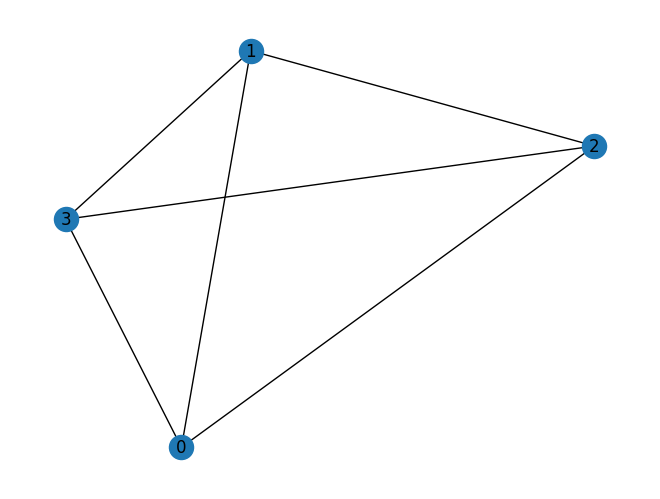

__________________________________________________

Number of nodes:  4
Number of edges:  6

Branch and bound
Path: 0 -> 1 -> 3 -> 2 -> 0
Weight:  15

Twice Around The Tree
Path: 0 -> 2 -> 3 -> 1 -> 0
Weight:  15.0

Christofides
Path: 0 -> 1 -> 3 -> 2 -> 0
Weight:  15.0

__________________________________________________


In [41]:
A = [[0, 3, 1, 5],
    [3, 0, 6, 7],
    [1, 6, 0, 4],
    [5, 7, 4, 0]]

G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.Graph)
showGraph(G)
printSolutionsReport(A, G)

Test 2

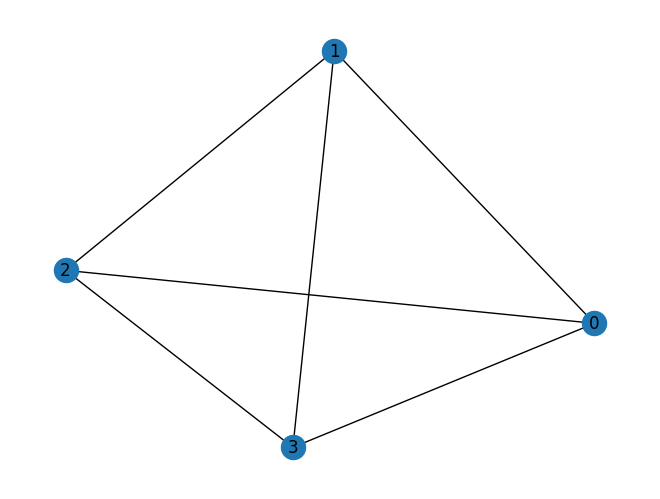

__________________________________________________

Number of nodes:  4
Number of edges:  6

Branch and bound
Path: 0 -> 1 -> 2 -> 3 -> 0
Weight:  29

Twice Around The Tree
Path: 0 -> 1 -> 2 -> 3 -> 0
Weight:  29.0

Christofides
Path: 0 -> 1 -> 3 -> 2 -> 0
Weight:  30.0

__________________________________________________


In [42]:
A = [[0, 4, 8, 9],
    [4, 0, 6, 8],
    [8, 6, 0, 10],
    [9, 8, 10, 0],   ]

G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.Graph)
showGraph(G)
printSolutionsReport(A, G)